# Homework 5: Oliver Muellerklein

Collaboration with Jacob Bukoski and Zhongqi Miao.

In [1]:
import sys

#sys.path.append('/usr/local/lib/python3.5/site-packages')
#sys.path

This homework requires a few steps for database work with SQL tables, building a template with CSV files, and then populating the SQL tables with data pulled from the web with *BeautifulSoup*. Using a utility SQL class and *SQLite3*, I do the initial steps with building the table framework from a blank SQL table and the CSV inferred guidelines. 

## SQL x Weather Underground

The first steps are to import some packages for later and create a helper / utility class for SQLite.


In [2]:
import pandas as pd
import numpy as np
import sqlite3
from bs4 import BeautifulSoup
from urllib.request import urlopen
from datetime import datetime
import matplotlib.pyplot as plt
#%matplotlib inline

class UtilSQL:
    """
        Helper utility class for SQL:

            * connect(..., database)

            * table_list(...)

            * drop(..., table)

            * close(...)
    """
    
    def __init__(self):
        self.db = None
        self.connection = None
        self.cursor = None
        
    def connect(self, database):
        self.db = database
        self.connection = sqlite3.connect(self.db)
        self.cursor = self.connection.cursor()
        
    def tableList(self):
        sqlCMD = "SELECT * FROM sqlite_master WHERE type = 'table';"
        self.cursor.execute(sqlCMD)
        dbMeta = self.cursor.fetchall()
        for entry in dbMeta: 
            print(entry)
            
    def drop(self, table):
        sqlCMD = "DROP TABLE %s" % (table)
        self.cursor.execute(sqlCMD)
            
    def close(self):
        self.connection.commit()
        self.connection.close()



### Extract clean dataframe from CSV

Next we want to use the given CSVs and extract a cleaner table / data structure for later use.


In [3]:
# Read in data from CSV
dataHead = pd.read_csv('hw_5_data/top_airports.csv')
icao = pd.read_csv('hw_5_data/ICAO_airports.csv')
icao = icao.rename(columns = {'iata_code' : 'IATA'})
dataMerge = pd.merge(dataHead, icao, on = ['IATA'])
dataFin = dataMerge[['ICAO', 'Airport', 'City', 'latitude_deg', 'longitude_deg', 'elevation_ft']]

### Initialize connection to SQL and begin!

Now we can begin to fill in our tables with a connection to our SQL database through our utility class. More below...

In [4]:
# Connect to SQL table
sql = UtilSQL()
sql.connect('HW5.db')

# Run SQL commands 

sqlCMD = """CREATE TABLE Top_Airport (ICAO TEXT, Airport TEXT,
            City TEXT, Latitude REAL, Longitude REAL, Elevation REAL,
            PRIMARY KEY (ICAO))"""
#sql.cursor.execute(sqlCMD)

#for i in range(len(dataFin)):
#    sqlCMD = ("INSERT INTO Top_Airport (ICAO, Airport, City, Latitude, Longitude, Elevation) VALUES " 
#               + str(tuple(dataFin.ix[i])))
#    sql.cursor.execute(sqlCMD)

sqlCMD = 'SELECT * FROM Top_Airport'

sql.cursor.execute(sqlCMD)

# Show data table (SQL table)
#sql.cursor.fetchall()

### Exploratory steps with BeautifulSoup

In [5]:
try:
    # For Python 3.0 and later
    from urllib.request import urlopen
except ImportError:
    # Fall back to Python 2's urllib2
    from urllib2 import urlopen
    
#response = urlopen("http://words.bighugelabs.com/")
#html = response.read()
#response.close()
# pip install beautifulsoup4
from bs4 import BeautifulSoup
#soup = BeautifulSoup(html, "html5lib")
#forms = soup.findAll("form")
#forms


We can begin with an example of how to scrape the **Weather Underground** data for a specific year (2008) using *BeautifulSoup*.


In [6]:
#response08 = urlopen("https://www.wunderground.com/history/airport/%s/%s/1/1/CustomHistory.html?dayend=31&monthend=12&yearend=%s" \
#                   % ('KATL', '2008', '2008'))
#html08 = response08.read()
#response08.close()
#soup08 = BeautifulSoup(html08, "html5lib")

# Try to pull a single year
#tbody08 = soup08.find('table', id = 'obsTable', class_ = 'responsive obs-table daily').find_all('tbody')

## A Class approach to generating weather data

There are multiple ways that the database could be connected and integrated with the web scraping of Weather Underground. The following class contains a few different methods and components that allow the data to be built either: 

**A)** outside of the class by connecting to the SQL data externally, i.e. no data is stored within an instance of this class 

or 

**B)** within the class through a mapping to the specific years, i.e. data is stored within an instance of the class 

I am providing the code here as references to all functionality but the actual data used in the remaining questions imports *hw5.db* - which is a result of using the class without any instance-specific data storage, i.e. option **A**.  

In [7]:
class Weather:
    
    def __init__(self):
        self.begin = None
        self.end = None
        self.icao = None
        self.tbody = None
        self.yearr = None
        self.monthh = None
        self.dayy = None
        self.icao = None
        
        self.counterr = 0
        self.monthIndx = []
        self.tryTd = None
        self.tbody08 = None
        self.tbody09 = None
        self.tbody10 = None
        self.tbody11 = None
        self.tbody12 = None
        self.tbody13 = None
        self.tbody14 = None
        self.tbody15 = None
        self.tbody16 = None
        self.yyear = None
        
        # Bunch of maps 
        self.getNumDayIncrease = {
            'Jan' : 32,
            'Feb' : 28
        }
        
        self.getTbody = {
            2008 : self.tbody08,
            2009 : self.tbody09,
            2010 : self.tbody10,
            2011 : self.tbody11,
            2012 : self.tbody12,
            2013 : self.tbody13,
            2014 : self.tbody14,
            2015 : self.tbody15,
            2016 : self.tbody16
        }

    global sql
    
    def setTbody(self):
        
        self.tbody = self.getTbody[self.yyear]
    
    def setTryTD(self):
        self.tryTd = self.tbody[self.counterr].find_all('td')[0].string
        tryIt = self.trySwitcher()

        if (tryIt):
            self.tryTd = self.tbody[self.counterr].find_all('td')[0].string
            tryIt = self.trySwitcher()
      
    
    def mapSwitcher(self, argument):
    
        switchh = {
            'Jan' : True,
            'Feb' : True
        }

        return switchh.get(argument, 'nothing')

    
    def trySwitcher(self):
        
        if (self.mapSwitcher(self.tryTd)):
            
            # Get index from tbody 
            self.monthIndx.append(self.counterr)
            self.counterr += self.getNumDayIncrease[self.tryTd]
            return False

        else:
            # Try again 
            self.counterr += 1
            return True
        
    def setYearData(self, icao, yyear):
        
        self.yyear = yyear
        self.getTbody[yyear] = self.fetch(icao, yyear)
    
    def fetch (self, icao, date):
        """
            Function from Miao: pull specific year stepwise. 
            Only connections, no internal class storage of tables.
            
            return: all tbody tags from HTML document (DOM)
        """

        response = urlopen("https://www.wunderground.com/history/airport/%s/%s/1/1/CustomHistory.html?dayend=31&monthend=12&yearend=%s" \
                           % (icao, date, date))
        html = response.read()
        response.close()
        soup = BeautifulSoup(html,"html5lib")
        tbody = soup.find('table', id = 'obsTable', class_ = 'responsive obs-table daily').find_all('tbody')
        return tbody
    
    def callback (self, row):
        """
            Function from Miao: Callback for iterative year HTML pull of data.
        """
    
        if 'avg' in row.text:
            self.monthh += 1
            self.dayy = 0

        #print(self.y, self.m, self.d)

        if self.dayy != 0:
            td = row.find_all('td')

            MaxT = td[2].text.strip()
            MeanT = td[1].text.strip()
            MinT = td[3].text.strip()
            MaxH = td[8].text.strip()
            MeanH = td[7].text.strip()
            MinH = td[9].text.strip()
            Prep = td[-2].text.strip()
            Date = datetime(self.yearr, self.monthh, self.dayy).date()
            
            sql.cursor.execute("""INSERT INTO Weather (ICAO, Date, MaxT, MeanT,
                            MinT, MaxH, MeanH, MinH, Prep) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?)""",
                                  (self.icao, Date, MaxT, MeanT, MinT, MaxH, MeanH, MinH, Prep))

        self.dayy += 1
    
    def popData (self, begin, end, icao):
        """
            Function from Miao: populate SQL table externally.
            Steps through each year of data and increments / counts 
            months and days - accounts for leap years etc. 
        """
    
        self.icao = icao
        
        for i in range(begin, end + 1):

            tbody = self.fetch(icao, i)
            self.yearr = i
            self.monthh = 0
            self.dayy = 0
            a = list(map(self.callback, tbody))

Below is a beginning example of using the **Weather** class to manually step through the years and months, iterively augmenting the data to the data map. *Note: the complete code for not incorporating the data into the class (which is the method we used to directly create the database file) is included below in the comments.*

In [8]:
weatherInst = Weather()
weatherInst.setYearData('KATL', 2008)
weatherInst.setTbody()
len(weatherInst.getTbody[2008])
weatherInst.setTryTD()

# Counterr is used to count through number of days per month 
#weatherInst.counterr

And here is the code for looping through and populating the SQL table directly, *i.e. this is the method that connects to and populates the SQL table externally without storing the data internally (in the class instance).*  

In [9]:
weatherInst = Weather()
for i in dataFin["ICAO"]:
    
    # i = the top 50 airports
    
    print("i: ", i)
    #weatherInst.popData(2008, 2016, i)

i:  KATL
i:  KORD
i:  KLAX
i:  KDFW
i:  KDEN
i:  KJFK
i:  KSFO
i:  KIAH
i:  KLAS
i:  KPHX
i:  KCLT
i:  KMIA
i:  KMCO
i:  KEWR
i:  KDTW
i:  KMSP
i:  KSEA
i:  KPHL
i:  KBOS
i:  KLGA
i:  KIAD
i:  KBWI
i:  KFLL
i:  KSLC
i:  PHNL
i:  KDCA
i:  KMDW
i:  KSAN
i:  KTPA
i:  KPDX
i:  KSTL
i:  KMCI
i:  KMEM
i:  KCLE
i:  KOAK
i:  TJSJ
i:  KRDU
i:  KBNA
i:  KSMF
i:  KHOU
i:  KSNA
i:  KAUS
i:  KSJC
i:  KMSY
i:  KPIT
i:  KSAT
i:  KCVG
i:  KMKE
i:  KDAL
i:  KIND


### Calculate correlation coefficient directly on SQL table

The next major step is calculating the correlation coefficient across all of the data. This could be performed after extracting the data into standard *Python* data structures / code, *i.e. Numpy arrays and use of numpy.corrcoeff()*. However, for greater optimization and learning purposes, the correlation coefficients are calculated directly on the SQL table.  

*Note table attributes:*

```
    Date
    MaxT = max daily temp
    MeanT = mean daily temp
    MinT = min daily temp
    MaxH = max daily humidity 
    MeanH = mean daily humidity
    MinH = min daily humidity
    Prep = precipitation
```


In [11]:
# Connect to SQL table
sql = UtilSQL()
sql.connect('HW5.db')

sqlCMD = """SELECT w1.icao, w1.date, w1.MeanT, w1.MinT, w1.MaxT, w1.MeanH, w1.MinH, w1.MaxH, w1.Prep, w2.icao, w2.date, w2.MeanT, w2.MinT, w2.MaxT, w2.MeanH, w2.MinT, w2.MaxT, w2.Prep, julianday(w1.date)
             FROM Weather w1, Weather w2 
             WHERE strftime('%Y', w1.date) = strftime('%Y', w2.date)
             AND strftime('%m', w1.date) = strftime('%m', w2.date)
             AND strftime('%d', w1.date) = strftime('%d', w2.date)
             AND w1.icao = 'KATL' 
             AND w2.icao = 'KPHX'
             AND typeof(w1.MeanT) = 'real'
             AND typeof(w1.MinT) = 'real'
             AND typeof(w1.MaxT) = 'real'
             AND typeof(w1.MeanH) = 'real'
             AND typeof(w1.MinH) = 'real'
             AND typeof(w1.MaxH) = 'real'
             AND typeof(w1.Prep) = 'real'
             AND typeof(w2.MeanT) = 'real'
             AND typeof(w2.MinT) = 'real'
             AND typeof(w2.MaxT) = 'real'
             AND typeof(w2.MeanH) = 'real'
             AND typeof(w2.MinH) = 'real'
             AND typeof(w2.MaxH) = 'real'
             AND typeof(w2.Prep) = 'real';"""

sql.cursor.execute(sqlCMD)
allTableData = sql.cursor.fetchall()
# len(allTableData)

Now we have created a Python data structure that contains the results of an SQL query on all matching data between **ATL** and **PHX** airports. The data structure has the following structure:
    

    * allTableData[i][0] = 'KATL' for day i
    * allTableData[i][1] = '...date...' for day i
    * allTableData[i][2] = mean temperature of ATL for day i
    * allTableData[i][3] = min temperature of ATL ...
    * allTableData[i][4] = max temperature of ATL ...
    * allTableData[i][5] = mean humidity of ATL ...
    * allTableData[i][6] = min humidity of ATL ...
    * allTableData[i][7] = max humidity of ATL ...
    * allTableData[i][8] = precipitation of ATL ...
    * allTableData[i][9] = 'KPHX' ...
    * allTableData[i][10] = '...date...' ...
    * allTableData[i][11] = mean temperature of PHX ...
    * allTableData[i][12] = min temperature of PHX ...
    * allTableData[i][13] = max temperature of PHX ...
    * allTableData[i][14] = mean humidity of PHX ...
    * allTableData[i][15] = min humidity of PHX ...
    * allTableData[i][16] = max humidity of PHX ...
    * allTableData[i][17] = precipitation of PHX ...
    * allTableData[i][18] = Julian day (for easier calculation of delta t or precip)

In [12]:

# Data in nested array 
rawDataStruct = []
rawTemp = []
rawHumid = []
rawPrecip = []
rawDTemp = []
rawDHumid = []
rawJDate = []

for i in allTableData:
    
    dtATL = i[4] - i[3]
    dhATL = i[7] - i[6]
    dtPHX = i[13] - i[12]
    dhPHX = i[16] - i[15] 
    
    rawDataStruct.append({'Date' : i[1], 'jDate' : i[18], 
                          'tATL' : i[2], 'dtATL' : dtATL, 'hATL' : i[5], 'dhATL' : dhATL, 'pATL' : i[8],
                         'tPHX' : i[11], 'dtPHX' : dtPHX, 'hPHX' : i[14], 'dhPHX' : dhPHX, 'pPHX' : i[17]})
    rawTemp.append({'date' : i[1], 'jDate' : i[18], 'tATL' : i[2], 'tPHX' : i[11]})  
    rawHumid.append({'date' : i[1], 'jDate' : i[18], 'hATL' : i[5], 'hPHX' : i[14]})
    rawPrecip.append({'date' : i[1], 'jDate' : i[18], 'pATL' : i[8], 'pPHX' : i[17]})
    rawDTemp.append({'date' : i[1], 'jDate' : i[18], 'dtATL' : dtATL, 'dtPHX' : dtPHX})
    rawDHumid.append({'date' : i[1], 'jDate' : i[18], 'dhATL' : dhATL, 'dhPHX' : dhPHX})
    rawJDate.append({'jDate' : i[18]})
    
pdAll = pd.DataFrame(rawDataStruct)
pdTemp = pd.DataFrame(rawTemp)
pdHumid = pd.DataFrame(rawHumid)
pdPrecip = pd.DataFrame(rawPrecip)
pdDTemp = pd.DataFrame(rawDTemp)
pdDHumid = pd.DataFrame(rawDHumid)
pdJDate = pd.DataFrame(rawJDate)


In [13]:
pdAll.head()

,Date,dhATL,dhPHX,dtATL,dtPHX,hATL,hPHX,jDate,pATL,pPHX,tATL,tPHX
0,2008-01-03,27.0,9.0,13.0,9.0,73.0,27.0,2454468.5,0.0,0.00,40.0,71.0
1,2008-01-04,21.0,11.0,11.0,11.0,60.0,54.0,2454469.5,0.0,0.00,47.0,73.0
2,2008-01-05,19.0,6.0,12.0,6.0,71.0,59.0,2454470.5,0.0,0.03,55.0,67.0
3,2008-01-06,15.0,3.0,13.0,3.0,82.0,93.0,2454471.5,0.0,0.02,67.0,62.0
4,2008-01-07,25.0,5.0,14.0,5.0,100.0,96.0,2454472.5,0.0,0.51,71.0,59.0


In [14]:
# Stack Pandas DataFrame and then sort to get top Z values in matrix

#pdAllStack = pdAll.stack()
#pdAllStack.sort(ascending = False)
#pdAllStack.head()

In other words, the top raw values within the data table are found at row **2559** and column **tPHX** with a value of **118.0**. This means the maximum raw value in the data table is the mean temperature for some day in PHX. 

In [15]:
pdTemp.head()

,date,jDate,tATL,tPHX
0,2008-01-03,2454468.5,40.0,71.0
1,2008-01-04,2454469.5,47.0,73.0
2,2008-01-05,2454470.5,55.0,67.0
3,2008-01-06,2454471.5,67.0,62.0
4,2008-01-07,2454472.5,71.0,59.0


In [16]:
pdDTemp.head()

,date,dtATL,dtPHX,jDate
0,2008-01-03,13.0,9.0,2454468.5
1,2008-01-04,11.0,11.0,2454469.5
2,2008-01-05,12.0,6.0,2454470.5
3,2008-01-06,13.0,3.0,2454471.5
4,2008-01-07,14.0,5.0,2454472.5


Here we show an alternative method for extracting SQL table attributes (query SQL table) to build a Python data structure in a stepwise pattern.

In [17]:
# Get features from specific observation 

def getTableFeatures(icao):

    global sql
    
    sqlCMD = """SELECT w1.Prep
                 FROM Weather w1 
                 WHERE w1.icao = '%s' 
                 AND typeof(w1.Prep) = 'real';""" % (icao)
    sql.cursor.execute(sqlCMD)
    result = sql.cursor.fetchall()
    return result

# pATL = prep predictor for ATL
pATL = getTableFeatures('KATL')

# pPHX = prep predictor for PHX
pPHX = getTableFeatures('KPHX')

#### A note about covariance matrices 

We will be using the **numpy** function *np.corrcoeff* to calculate a normalized covariance measurement of our database. The normalized covariance returns the coefficients (per *n*, observations, i.e. per airport) from the covariance matrix. The covariance matrix is calculated with the following:

```
    * n = number of observations 
    * p = number of predictors 
    * n x p = dimensions of the data 
    * N = [n_1, n_2, ... , n_z]**T - all observations transposed
    * C_ij = covariance of n_i and n_j
    * C_ii = variance of n_i
    * R_ij = C_ij / sqrt(C_ii * C_jj)
```

The covariance is calculated using N (the observations transposed) and produces a **n x n** matrix with the following values: 

```
    If the value of C_ij is close to 1: 
        near perfect positive linear relationship / correlation between n_i and n_j
    If the value of C_ij is close to -1:
        near perfect negative linear relationship / correlation between n_i and n_j
    If the value of C_ij is 0:
        no relationship between n_i and n_j
```

In [18]:
# Speed up the calculation of the covariance 
def speedUpCov(Ni, Nj):
    Nim = np.reshape(np.mean(Ni, axis = 1), (Ni.shape[0], 1))
    Njm = np.mean(Nj)
    Cij = np.sum((Ni - Nim) * (Nj - Njm), axis = 1)
    Ciijj = np.sqrt(np.sum((Ni - Nim)**2, axis = 1) * np.sum((Nj - Njm)**2))
    Rij = Cij / Ciijj
    return Rij


We can generate the covariance matrices for each pair of data, *i.e. a feature from airport X and the same feature from airport Y*. 

The **correlation coefficients** - per *n* (i.e. airport) - can be calculated from normalizing the covariance matrix. We can compute the pairwise correlations of columns using the *Pearson correlation coefficient* test from the Pandas function **pd.corr()**.  

In [19]:
tCorr = pdTemp.corr()
hCorr = pdHumid.corr()
pCorr = pdPrecip.corr()
dtCorr = pdDTemp.corr()
dhCorr = pdDHumid.corr()

tCorrValue = tCorr.ix['tATL']['tPHX']
hCorrValue = hCorr.ix['hATL']['hPHX']
pCorrValue = pCorr.ix['pATL']['pPHX']
dtCorrValue = dtCorr.ix['dtATL']['dtPHX']
dhCorrValue = dhCorr.ix['dhATL']['dhPHX']

corrValues = {
    "tMean" : tCorrValue,
    "hMean" : hCorrValue, 
    "precip" : pCorrValue, 
    "dTemp" : dtCorrValue, 
    "dHumid" : dhCorrValue
}

In [20]:
corrValues

{'dHumid': 0.046232260357963219,
 'dTemp': 0.0012335313652307798,
 'hMean': 0.015329177189899422,
 'precip': -0.0032019456056078636,
 'tMean': 0.74126728749423831}

In [21]:
ttATL = np.array(pdTemp[['tATL']]).transpose()
ttPHX = np.array(pdTemp[['tPHX']]).transpose()

In [22]:
np.corrcoef(ttATL, ttPHX)

array([[ 1.        ,  0.74126729],
       [ 0.74126729,  1.        ]])

The newly created array (list) of correlation coefficients between **ATL and PHX** using:

* corrValues['tMean'] = mean temperature
* corrValues['hMean'] = mean humidity 
* corrValues['precip'] = precipitation
* corrValues['dTemp'] = daily delta temperature 
* corrValues['dHumid'] = daily delta humidity


### So what features are correlated? 

We can pull out whatever the highest correlation is between the two locations, *i.e. ATL and PHX*. With a high correlation we can expect that a linear regression between the two airports using that feature will produce a predictive measurement. 

However, these correlations are all based on the Pearson correlation coefficient test, which assumes the data is normally distributed. We can examine this 'truth' through manually checking the data distributions and then involving the **Scipy function scipy.pearsonr()** - the *p-value* returned is from a two-tail probability test.

In [23]:
# Sort matrix and pull out the top Z greatest values (from descending data structure)

#pdAllStack = pdAll.stack()
#pdAllStack.sort(ascending = False)
#pdAllStack.head()

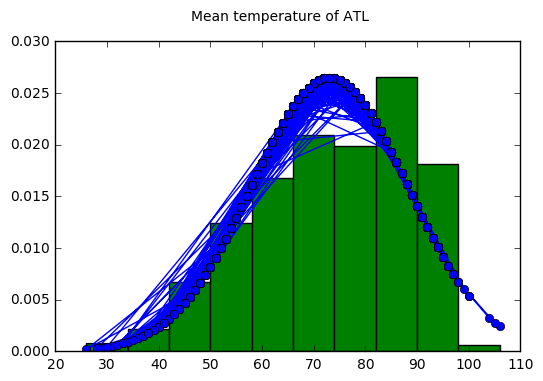

In [25]:
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

tATL = np.array(pdTemp[['tATL']])
tATLsort = np.sort(tATL)
tATLfit = stats.norm.pdf(tATLsort, np.mean(tATLsort), np.std(tATLsort))

plt.plot(tATLsort, tATLfit, '-o')
plt.hist(tATLsort, normed = True)
plt.suptitle("Mean temperature of ATL")
plt.show()

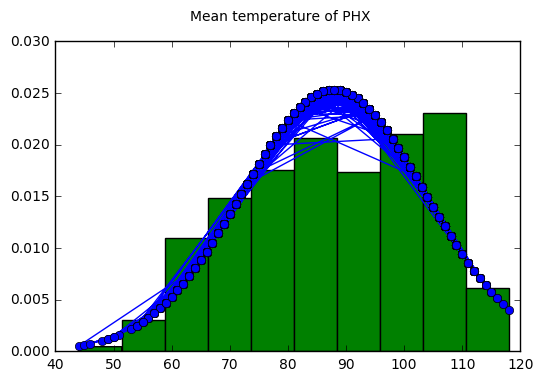

In [26]:
%matplotlib inline

tPHX = np.array(pdTemp[['tPHX']])
tPHXsort = np.sort(tPHX)
tPHXfit = stats.norm.pdf(tPHXsort, np.mean(tPHXsort), np.std(tPHXsort))

plt.plot(tPHXsort, tPHXfit, '-o')
plt.hist(tPHXsort, normed = True)
plt.suptitle("Mean temperature of PHX")
plt.show()

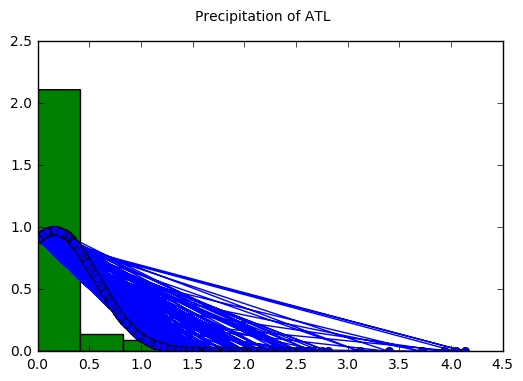

In [27]:
%matplotlib inline

pATL = np.array(pdPrecip[['pATL']])
pATLsort = np.sort(pATL)
pATLfit = stats.norm.pdf(pATLsort, np.mean(pATLsort), np.std(pATLsort))

plt.plot(pATLsort, pATLfit, '-o')
plt.hist(pATLsort, normed = True)
plt.suptitle("Precipitation of ATL")
plt.show()

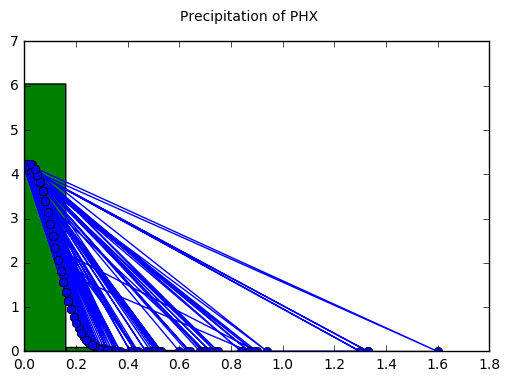

In [28]:
%matplotlib inline

pPHX = np.array(pdPrecip[['pPHX']])
pPHXsort = np.sort(pPHX)
pPHXfit = stats.norm.pdf(pPHXsort, np.mean(pPHXsort), np.std(pPHXsort))

plt.plot(pPHXsort, pPHXfit, '-o')
plt.hist(pPHXsort, normed = True)
plt.suptitle("Precipitation of PHX")
plt.show()

In [32]:
# And now Pearson test

stats.pearsonr(tATL, tPHX)[0]

array([ 0.74126729])

In [33]:
# And numpy correlation coefficient 

np.corrcoef(ttATL, ttPHX)

array([[ 1.        ,  0.74126729],
       [ 0.74126729,  1.        ]])

It seems that the precipitation data for either **ATL** nor **PHX** do not follow a normal distribution, though the mean temperatures look passing. Next we will use the change in temperatures and precipitation based on **1, 3, and 7 day advances** to find the correlations between these two airports. This is one method to calculate the correlations between changes over a fixed number of days at one airport to another airport, allowing predictions to occur for either temperature or precipitation. 

### Sliding delta t or h windows 

Slide over rows of data to calculate the change of (*i.e. delta*) temperature and precipitation based on windows of **1 day, 3 days, or 7 days**. 


In [34]:
import math

# Get number of days total 
numDays = pdJDate.max() - pdJDate.min()

# Get number of steps in data 
numSteps = pdTemp.shape[0]

# Get number of missing days 
numMissing = numDays - numSteps 

# Get first day for Julian Dates 
jFirst = math.floor(pdJDate.min())

# Get last day for Julian Dates
jLast = math.floor(pdJDate.max())
jFirst

2454468

In [35]:
jLast

2457667

In [36]:
# Need to find how many 1, 3, and 7s go into the number of steps 

oneSteps = math.floor(numDays / 1)
oneRemain = numDays % 1

threeSteps = math.floor(numDays / 3)
threeRemain = numDays % 3

sevenSteps = math.floor(numDays / 7)
sevenRemain = numDays % 7

In [37]:
# Create 1, 3, and 7 step dates starting from jFirst 

threeDates = []

for i in range(0, threeSteps + 1):
        threeDates.append({'jDate' : jFirst + (i * 3)})
    
pdThreeDates = pd.DataFrame(threeDates)

In [38]:
pdThreeDates.head()

,jDate
0,2454468
1,2454471
2,2454474
3,2454477
4,2454480


In [39]:
# ... rest of the step dates

oneDates = []

for i in range(0, oneSteps + 1):
        oneDates.append({'jDate' : jFirst + i})        
pdOneDates = pd.DataFrame(oneDates)

sevenDates = []

for i in range(0, sevenSteps + 1):
        sevenDates.append({'jDate' : jFirst + (i * 7)})
pdSevenDates = pd.DataFrame(sevenDates)


In [40]:
pdSevenDates.head()

,jDate
0,2454468
1,2454475
2,2454482
3,2454489
4,2454496


### Extract features for projected days

Now that we have the projected 1, 3, and 7 day dates across all of the years, we can pull the temperature and humidity values for the corresponding dates from the data table.

In [41]:
# Find all the days in temp / precip that match the jDate

pdTemp.head()

,date,jDate,tATL,tPHX
0,2008-01-03,2454468.5,40.0,71.0
1,2008-01-04,2454469.5,47.0,73.0
2,2008-01-05,2454470.5,55.0,67.0
3,2008-01-06,2454471.5,67.0,62.0
4,2008-01-07,2454472.5,71.0,59.0


In [98]:
pdPrecip.head()

,date,jDate,pATL,pPHX
0,2008-01-03,2454468.5,0.0,0.00
1,2008-01-04,2454469.5,0.0,0.00
2,2008-01-05,2454470.5,0.0,0.03
3,2008-01-06,2454471.5,0.0,0.02
4,2008-01-07,2454472.5,0.0,0.51


In [104]:
tempATL = np.array(pdTemp[['tATL']])     # 2645
precipATL = np.array(pdPrecip[['pATL']])   # 2645

tempPHX = np.array(pdTemp[['tPHX']])     # 2645
precipPHX = np.array(pdPrecip[['pPHX']])   # 2645

In [96]:
tATL = np.array(pdTemp[['jDate']])     # 2645
pATL = np.array(pdPrecip[['jDate']])   # 2645

tPHX = np.array(pdTemp[['jDate']])     # 2645
pPHX = np.array(pdPrecip[['jDate']])   # 2645

npOneDates = np.array(pdOneDates[['jDate']])      # 3200
npThreeDates = np.array(pdThreeDates[['jDate']])  # 1067
npSevenDates = np.array(pdSevenDates[['jDate']])  # 458

In [95]:
dtOneATL = []
dtOnePHX = []
dpOneATL = []
dpOnePHX = []

for i in range(0, 2644):
    
    # Check for one day sliding window 
    for j in range(0, 3199):
        
        if ((npOneDates[j] == math.floor(tATL[i])) and (npOneDates[j + 1] == math.floor(tATL[i + 1]))):
            
            tmpDelta = tempATL[i + 1] - tempATL[i]
            dtOneATL.append(tmpDelta)
            
        if ((npOneDates[j] == math.floor(tPHX[i])) and (npOneDates[j + 1] == math.floor(tPHX[i + 1]))): 
            
            tmpDelta = tempPHX[i + 1] - tempPHX[i]
            dtOnePHX.append(tmpDelta)
            
        if ((npOneDates[j] == math.floor(pATL[i])) and (npOneDates[j + 1] == math.floor(pATL[i + 1]))):
            
            tmpDelta = pATL[i + 1] - pATL[i]
            dpOneATL.append(tmpDelta)
            
        if ((npOneDates[j] == math.floor(pPHX[i])) and (npOneDates[j + 1] == math.floor(pPHX[i + 1]))): 
            
            tmpDelta = pPHX[i + 1] - pPHX[i]
            dpOnePHX.append(tmpDelta)
            
        
        
    

In [105]:
dtThreeATL = []
dtThreePHX = []
dpThreeATL = []
dpThreePHX = []

for i in range(0, 2642):
    
    # Check for one day sliding window 
    for j in range(0, 1064):
        
        if ((npOneDates[j] == math.floor(tATL[i])) and (npOneDates[j + 3] == math.floor(tATL[i + 3]))):
            
            tmpDelta = tempATL[i + 3] - tempATL[i]
            dtThreeATL.append(tmpDelta)
            
        if ((npOneDates[j] == math.floor(tPHX[i])) and (npOneDates[j + 3] == math.floor(tPHX[i + 3]))): 
            
            tmpDelta = tempPHX[i + 3] - tempPHX[i]
            dtThreePHX.append(tmpDelta)
            
        if ((npOneDates[j] == math.floor(pATL[i])) and (npOneDates[j + 3] == math.floor(pATL[i + 3]))):
            
            tmpDelta = precipATL[i + 3] - precipATL[i]
            dpThreeATL.append(tmpDelta)
            
        if ((npOneDates[j] == math.floor(pPHX[i])) and (npOneDates[j + 3] == math.floor(pPHX[i + 3]))): 
            
            tmpDelta = precipPHX[i + 3] - precipPHX[i]
            dpThreePHX.append(tmpDelta)
            
        

In [106]:
dtSevenATL = []
dtSevenPHX = []
dpSevenATL = []
dpSevenPHX = []

for i in range(0, 2638):
    
    # Check for seven day sliding window 
    for j in range(0, 451):
        
        if ((npSevenDates[j] == math.floor(tATL[i])) and (npSevenDates[j + 7] == math.floor(tATL[i + 7]))):
            
            tmpDelta = timeATL[i + 7] - timeATL[i]
            dtSevenATL.append(tmpDelta)
            
        if ((npSevenDates[j] == math.floor(tPHX[i])) and (npSevenDates[j + 7] == math.floor(tPHX[i + 7]))): 
            
            tmpDelta = timePHX[i + 7] - timePHX[i]
            dtSevenPHX.append(tmpDelta)
            
        if ((npSevenDates[j] == math.floor(pATL[i])) and (npSevenDates[j + 7] == math.floor(pATL[i + 7]))):
            
            tmpDelta = precipATL[i + 7] - precipATL[i]
            dpSevenATL.append(tmpDelta)
            
        if ((npSevenDates[j] == math.floor(pPHX[i])) and (npSevenDates[j + 7] == math.floor(pPHX[i + 7]))): 
            
            tmpDelta = precipPHX[i + 7] - precipPHX[i]
            dpSevenPHX.append(tmpDelta)
            
        

In [116]:
npTThreeATL = np.array(dtThreeATL).transpose()
npTThreePHX = np.array(dtThreePHX).transpose()
npPThreeATL = np.array(dpThreeATL).transpose()
npPThreePHX = np.array(dpThreePHX).transpose()

In [118]:
np.corrcoef(npTThreeATL, npTThreePHX)

array([[ 1.        , -0.30468015],
       [-0.30468015,  1.        ]])

In [119]:
np.corrcoef(npPThreeATL, npPThreePHX)

array([[ 1.        ,  0.02787096],
       [ 0.02787096,  1.        ]])

#### Show distributions of data

Again, the Pearson correlation coefficient assumes a normal distribution of the data. Thus, we will take a look: 

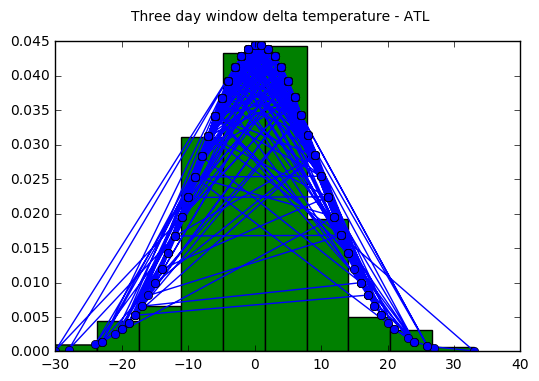

In [122]:
%matplotlib inline

tATL = np.array(dtThreeATL)
tPHX = np.array(dtThreePHX)
pATL = np.array(dpThreeATL)
pPHX = np.array(dpThreePHX)
tATLsort = np.sort(tATL)
tATLfit = stats.norm.pdf(tATLsort, np.mean(tATLsort), np.std(tATLsort))

plt.plot(tATLsort, tATLfit, '-o')
plt.hist(tATLsort, normed = True)
plt.suptitle("Three day window delta temperature - ATL")
plt.show()

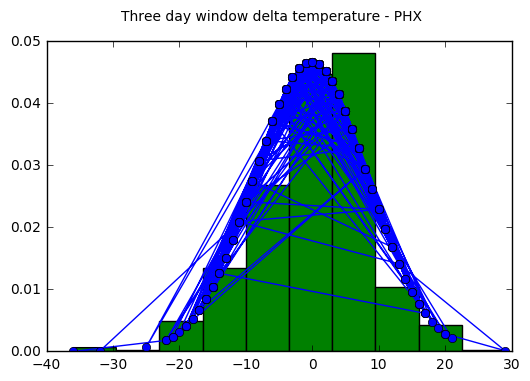

In [123]:
%matplotlib inline

tPHXsort = np.sort(tPHX)
tPHXfit = stats.norm.pdf(tPHXsort, np.mean(tPHXsort), np.std(tPHXsort))

plt.plot(tPHXsort, tPHXfit, '-o')
plt.hist(tPHXsort, normed = True)
plt.suptitle("Three day window delta temperature - PHX")
plt.show()

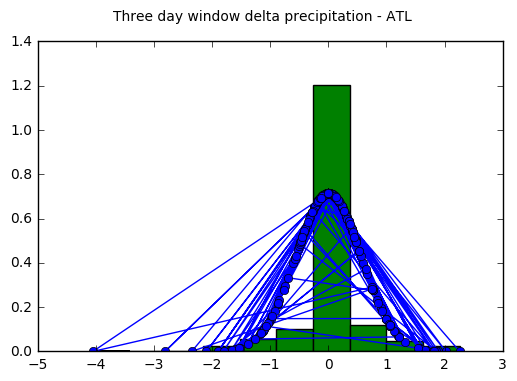

In [124]:
%matplotlib inline

pATLsort = np.sort(pATL)
pATLfit = stats.norm.pdf(pATLsort, np.mean(pATLsort), np.std(pATLsort))

plt.plot(pATLsort, pATLfit, '-o')
plt.hist(pATLsort, normed = True)
plt.suptitle("Three day window delta precipitation - ATL")
plt.show()

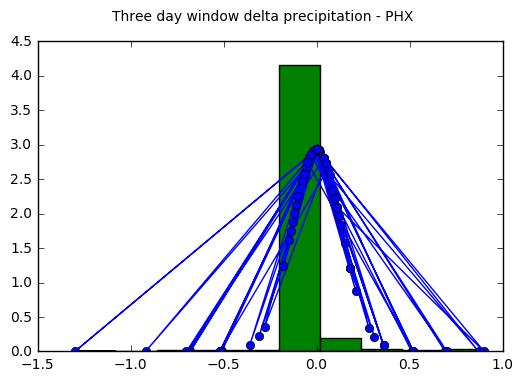

In [125]:
%matplotlib inline

pPHXsort = np.sort(pPHX)
pPHXfit = stats.norm.pdf(pPHXsort, np.mean(pPHXsort), np.std(pPHXsort))

plt.plot(pPHXsort, pPHXfit, '-o')
plt.hist(pPHXsort, normed = True)
plt.suptitle("Three day window delta precipitation - PHX")
plt.show()

### Get top 10 airport pairs 

Finally, we can use a combination of techniques and methods described above to obtain the top 10 pairs of airports based on various windows of days

*Note: I purposefully used a different sliding day window technique here to challenge myself and show another way to approach these problems.*

Also, it is important to note that there were a few ways to execute the end of this assignment with finding the top 10 airports based on either temperature or precipitation (and then plotting). However, here we use a concise, quick method that **does not** completely account for all measures of variation, accountibility, or predictive power within the data. This method will calculate the covariance of the entire database and then the correlation coefficients of the top 10 pairs based on covariance. An alternative approach can be viewed directly below, with the full execution commented out. 

In [127]:
# Alternative approach that calculates the correlation coefficients for every pair and then 
# extracts the top 10 pairs. This is significantly longer computationally. 

import itertools

def getPairData(airr_i, airr_j, featt, dayWindow):
    """
        Function from Miao: query SQL database for sliding day window around some feature.
        
        airr_i: airport i 
        airr_j: airport j
        featt: the feature to pivot around 
        dayWindow: the size of the day window (from Julian date)
    """

    sqlCMD = """SELECT w1.%s, w2.%s
                 FROM Weather w1, Weather w2 
                 WHERE julianday(w2.date) - julianday(w1.date) = %s
                 AND w1.icao = '%s' 
                 AND w2.icao = '%s'
                 AND typeof(w1.%s) = 'real'
                 AND typeof(w2.%s) = 'real';""" % (featt, featt, dayWindow, airr_i, airr_j, featt, featt)

    sql.cursor.execute(sqlCMD)
    return sql.cursor.fetchall()

def getTopCorr(featt, dayWindow, numTop):
    """
        Get the top N pairs based on the feature P in the window size K:
        
        numTop (N): the number of top observations to pull
        featt (P): the feature to pivot and sort on
        dayWindow (K): size of the sliding day window 
    """

    rawCorrs = []

    # n choose k, n = number of airports, k = 2 (i.e. all pair combos)
    for i in list(itertools.combinations(dataFin['ICAO'], 2)):

        arr_ij = np.array(list(map(lambda row : [row[0], row[1]], getPairData(i[0], i[1], featt, dayWindow)))).transpose()
        corr_ij = np.corrcoef(arr_ij)[0, 1]
        rawCorrs.append([i, corr_ij])

    topCorrs = sorted(rawCorrs, key = lambda element: element[1])[:numTop]

    return topCorrs


In [128]:
# Revolve around one feature, window size, and number of top airports to pull
#temp_top10_1day = getTopCorr('MeanT', 1, 10)
#temp_top10_3day = getTopCorr('MeanT', 3, 10)
#temp_top10_7day = getTopCorr('MeanT', 7, 10)

In [130]:
#precip_top10_1day = getTopCorr('Prep', 1, 10)
#precip_top10_3day = getTopCorr('Prep', 3, 10)
#precip_top10_7day = getTopCorr('Prep', 7, 10)

In [142]:
# Method used for remainder of homework 

def getAllWeather(icao, featt):
    """
        Get all weather data based on features in args
    """
    sqlCMD = """SELECT %s
                FROM Weather
                WHERE icao = '%s'
                AND typeof(%s) = 'real';""" % (featt, icao, featt)
    sql.cursor.execute(sqlCMD)
    return sql.cursor.fetchall()

def setTopNCov(featt, numTop = 10):
    
    rawDF = []

    for i in dataFin['ICAO']:
        rawDF.append(list(map(lambda row : row[0], getAllWeather(i, featt))))

    pdDF = pd.DataFrame(rawDF).transpose()
    pdDF.columns = list(dataFin['ICAO'])
    corr_ij = pdDF.corr()
    sCorr_ij = corr_ij.stack()
    sCorr_ij.sort(ascending = False)
    return sCorr_ij[50:60].iloc[::2]

# The above two functions can be used to approximate what 
# the below two functions do. Specifically, the above 
# finds the correlation of the entire matrix and then 
# calculates the top 10 pairs' coefficients whereas 
# the below (commented out) calculate the coefficients 
# for every pair, a 50 choose 2 number of corrcoef calls.
# 
# def getPairData(airr_i, airr_j, featt, dayWindow)
# def getTopCorr(featt, dayWindow, numTop)

# Here is the approximator / smooth function that can be 
# used as an analog of 'getTopCorr(...)'
def getTopCorrApprox(featt, dayWindow):
    rawDF = []
    if featt == 'MeanT':
        rawPairs = tTopp.index.values
    elif featt == 'Prep':
        rawPairs = pTopp.index.values
        
    for i in rawPairs:
        airr = np.array(list(map(lambda row : [row[0], row[1]], getPairData(i[0], i[1], featt, dayWindow)))).transpose()
        # Just get single value of coefficient - know it is only 1 since forcing pairwise
        corr_ij = np.corrcoef(airr)[0, 1]
        rawDF.append([i, corr_ij])
    return rawDF

In [143]:
tTopp = setTopNCov('MeanT')
pTopp = setTopNCov('Prep')

tOneCoef = getTopCorrApprox('MeanT', 1)
tThreeCoef = getTopCorrApprox('MeanT', 3)
tSevenCoef = getTopCorrApprox('MeanT', 7)

pOneCoef = getTopCorrApprox('Prep', 1)
pThreeCoef = getTopCorrApprox('Prep', 3)
pSevenCoef = getTopCorrApprox('Prep', 7)

/Users/kschocz/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:25: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


Now we have the top 10 airport pairs for temperature and precipitation based on **1, 3, and 7 days** - seperately between sliding day windows as well as between features. Next we need to find the distances between those top pairs and plot the values of the correlations as functions of the distance to see if there is a linear or otherwise interesting relationship between these predictive measures and the geographical (i.e. lat and long) distances.  

#### Find geographic distances 

Now we can use the following two functions to calculate the distances between the top airports (this code was primarily referenced from web examples / tutorials).

In [153]:
def getDistance(lat_i, lon_i, lat_j, lon_j):
    dLon = lon_j - lon_i
    dLat = lat_j - lat_i
    rawDist = (np.sin(dLat / 2))**2 + np.cos(lat_i) * np.cos(lat_j) * (np.sin(dLon / 2))**2 
    curveDist = 2 * np.arctan2(np.sqrt(rawDist), np.sqrt(1 - rawDist)) 
    distt = 6373 * curveDist
    return distt

def setDistList(featt):
    """
        Augment pairwise distances between top airports
        and return list (array) of approximated distances.
    """
    
    approxDists = []
    lonDists = []
    if featt == 'MeanT':
        rawPairs = tTopp.index.values
    elif featt == 'Prep':
        rawPairs = pTopp.index.values
        
    for i in rawPairs:
        dEucli = getDistance(float(dataFin[dataFin['ICAO'] == i[0]]['latitude_deg']), 
                             float(dataFin[dataFin['ICAO'] == i[0]]['longitude_deg']), 
                             float(dataFin[dataFin['ICAO'] == i[1]]['latitude_deg']), 
                             float(dataFin[dataFin['ICAO'] == i[1]]['longitude_deg']))
        
        dLonn = getDistance(0, float(dataFin[dataFin['ICAO'] == i[0]]['longitude_deg']),
                        0, float(dataFin[dataFin['ICAO'] == i[1]]['longitude_deg']))
        approxDists.append([i, dEucli])
        lonDists.append([i, dLonn])
        
    approxDistNP = np.array(approxDists).transpose()
    lonDistNP = np.array(lonDists).transpose()
    
    return (approxDistNP, lonDistNP)

In [156]:
pTOneCoef = np.array(pOneCoef).transpose()
pTThreeCoef = np.array(pThreeCoef).transpose()
pTSevenCoef = np.array(pSevenCoef).transpose()

tTOneCoef = np.array(tOneCoef).transpose()
tTThreeCoef = np.array(tThreeCoef).transpose()
tTSevenCoef = np.array(tSevenCoef).transpose()

tDistt = setDistList('MeanT')
pDistt = setDistList('Prep')

pdPrepFinal = pd.DataFrame([pDistt[0][0], pDistt[0][1], pDistt[1][1], 
                            pTOneCoef[1], pTThreeCoef[1], pTSevenCoef[1]]).transpose()

pdTempFinal = pd.DataFrame([tDistt[0][0], tDistt[0][1], tDistt[1][1], 
                            tTOneCoef[1], tTThreeCoef[1], tTSevenCoef[1]]).transpose()

pdPrepFinal.columns = ['icao', 'Real_Distance', 'Lon_Distance', 'One_Day', 'Three_Day', 'Seven_Day']
pdTempFinal.columns = ['icao', 'Real_Distance', 'Lon_Distance', 'One_Day', 'Three_Day', 'Seven_Day']

/Users/kschocz/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


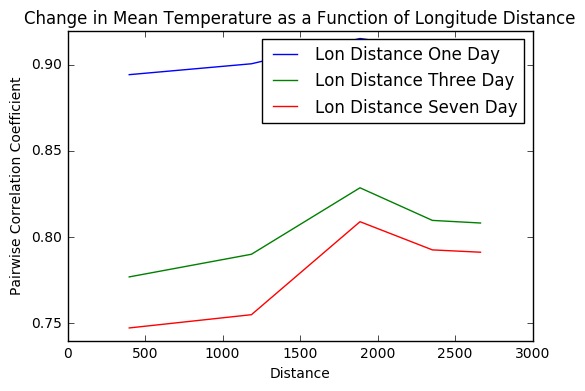

In [159]:
%matplotlib inline

tempSort = pdTempFinal.sort('Lon_Distance')
f, ax = plt.subplots()
ax.plot(tempSort['Lon_Distance'], tempSort['One_Day'], label = 'Lon Distance One Day')
ax.legend()
ax.plot(tempSort['Lon_Distance'], tempSort['Three_Day'], label = 'Lon Distance Three Day')
ax.legend()
ax.plot(tempSort['Lon_Distance'], tempSort['Seven_Day'], label = 'Lon Distance Seven Day')
ax.legend()
ax.set_title('Change in Mean Temperature as a Function of Longitude Distance')
ax.set_xlabel('Distance')
ax.set_ylabel('Pairwise Correlation Coefficient')

### Mean Temperature via Longitudal Distance

We can see that there is a slight positive relationship between *goodness of correlation* (i.e. Correlation Coefficient) and the Longitudal distance between pairs. In addition, the addition of a few extra days - three days versus one day difference - has a greater effect on the relationship than the additional four days from three to seven. This implies that there is a non-linear relationship between the addition of day advances and the distance for pairwise correlations - using mean temperature. Lastly, note the hump in the correlation strength, perhaps implying that the effects of distance smooth out once very far away, thus, reducing the influence of that feature on correlation. Similar behavior can be seen when using precipitation. It seems there is a sort of threshold (*not quite the correct word, maybe I mean 'activation threshold'*) where the influence of certain features will follow a specific trend - e.g. here we see almost a decay in influence as a function of longitudal distance - until they dramatically change behavior. Although it looks as though for very far away distances the correlation becomes way better, I think it is actually an artifact of the data or statistical analysis. In other words, I think the simulated model loses validity there. 

/Users/kschocz/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


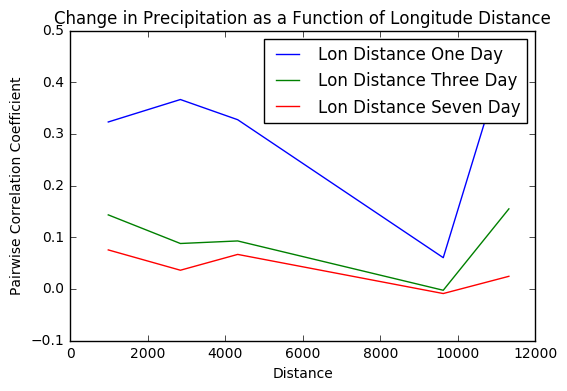

In [158]:
%matplotlib inline

precipSort = pdPrepFinal.sort('Lon_Distance')
f, ax = plt.subplots()
ax.plot(precipSort['Lon_Distance'], precipSort['One_Day'], label = 'Lon Distance One Day')
ax.legend()
ax.plot(precipSort['Lon_Distance'], precipSort['Three_Day'], label = 'Lon Distance Three Day')
ax.legend()
ax.plot(precipSort['Lon_Distance'], precipSort['Seven_Day'], label = 'Lon Distance Seven Day')
ax.legend()
ax.set_title('Change in Precipitation as a Function of Longitude Distance')
ax.set_xlabel('Distance')
ax.set_ylabel('Pairwise Correlation Coefficient')

/Users/kschocz/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


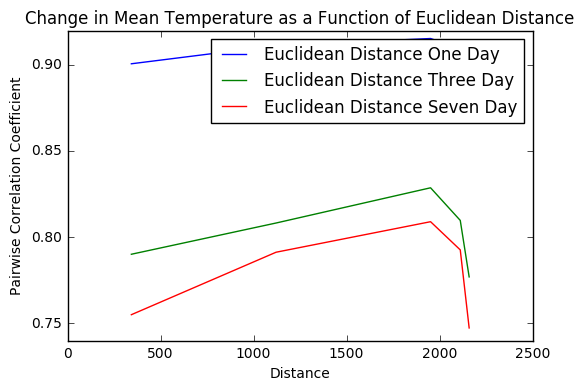

In [160]:
%matplotlib inline

tempSort = pdTempFinal.sort('Real_Distance')
f, ax = plt.subplots()
ax.plot(tempSort['Real_Distance'], tempSort['One_Day'], label = 'Euclidean Distance One Day')
ax.legend()
ax.plot(tempSort['Real_Distance'], tempSort['Three_Day'], label = 'Euclidean Distance Three Day')
ax.legend()
ax.plot(tempSort['Real_Distance'], tempSort['Seven_Day'], label = 'Euclidean Distance Seven Day')
ax.legend()
ax.set_title('Change in Mean Temperature as a Function of Euclidean Distance')
ax.set_xlabel('Distance')
ax.set_ylabel('Pairwise Correlation Coefficient')

/Users/kschocz/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


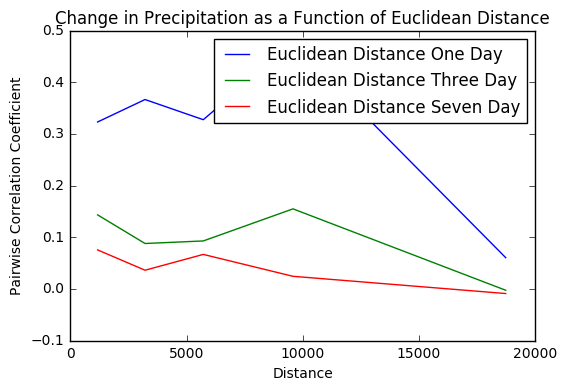

In [161]:
%matplotlib inline

precipSort = pdPrepFinal.sort('Real_Distance')
f, ax = plt.subplots()
ax.plot(precipSort['Real_Distance'], precipSort['One_Day'], label = 'Euclidean Distance One Day')
ax.legend()
ax.plot(precipSort['Real_Distance'], precipSort['Three_Day'], label = 'Euclidean Distance Three Day')
ax.legend()
ax.plot(precipSort['Real_Distance'], precipSort['Seven_Day'], label = 'Euclidean Distance Seven Day')
ax.legend()
ax.set_title('Change in Precipitation as a Function of Euclidean Distance')
ax.set_xlabel('Distance')
ax.set_ylabel('Pairwise Correlation Coefficient')

### Finally, the Real Distances 

Using what I call 'Euclidean distance' (*I only qualify this because it may not technically be Euclidean distance depending on how it was calculated from Lat and Long - but the point of it being from both Lat and Long rather than just Longitudal distance is non-trival*), we see a similar trend for both temperature and precipitation as functions of distance. There are dramatic decreases in correlation coefficients, suggesting a non-linear (and perhaps complex) interaction(s). Further, the influence of sliding day window size is very similar to using Longitudal distance, which is expected - to elaborate, the influence of the day window size should be proportionally affecting Longitudal and Euclidean distances. 